In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9953536668551597624
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9886851721929183910
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
import pathlib
import string
import re
import io
import os
from string import digits
from numpy import array,argmax,random,take
import pickle as pkl
from pickle import dump
from pickle import load
from numpy.random import rand
from numpy.random import shuffle
from unicodedata import normalize
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense, LSTM, Embedding, RepeatVector, Input, Concatenate, TimeDistributed, Bidirectional, TextVectorization
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
%matplotlib inline
import seaborn as sns
from nltk.translate.bleu_score import corpus_bleu
sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', 200)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from pickle import dump,load
import pickle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# text_file = keras.utils.get_file(
#     fname="spa-eng.zip",
#     origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
#     extract=True,
# )
# text_file ="/content/drive/MyDrive/NMT/translation dataset/spa.txt"
text_file ="/content/drive/MyDrive/NeuralMachineTranslation/datasets/spa.txt"

# ENGLISH TO SPANISH

In [ ]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")[:2]
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))
  
print(text_pairs[1])

('Go.', '[start] Vete. [end]')


In [ ]:
for i in range(5):
    print(text_pairs[i])

('Go.', '[start] Ve. [end]')
('Go.', '[start] Vete. [end]')
('Go.', '[start] Vaya. [end]')
('Go.', '[start] Váyase. [end]')
('Hi.', '[start] Hola. [end]')


In [ ]:
random.shuffle(text_pairs)
# num_val_samples = int(0.15 * len(text_pairs))
# num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:85000]
val_pairs = text_pairs[85000 : 99000]
test_pairs = text_pairs[99000 : 100000]
# train_pairs = text_pairs[:90000]
# val_pairs = text_pairs[90000 : 100000]
# test_pairs = text_pairs[100000 : 101000]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

138437 total pairs
85000 training pairs
14000 validation pairs
1000 test pairs


In [ ]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/input_eng.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/input_eng.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_eng = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_eng = TextVectorization.from_config(pickle_obj_eng["config"])
vector_eng.set_vocabulary(pickle_obj_eng["vocabulary"])
vector_eng.set_weights(pickle_obj_eng["weights"])

# NOW "vector" can be used in same way

In [ ]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/output_spa.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/output_spa.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_spa = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_spa = TextVectorization.from_config(pickle_obj_spa["config"])
vector_spa.set_vocabulary(pickle_obj_spa["vocabulary"])
vector_spa.set_weights(pickle_obj_spa["weights"])

# NOW "vector" can be used in same way

In [ ]:
def format_dataset(eng, spa):
    eng = vector_eng(eng)
    spa = vector_spa(spa)
    return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])

vocab_size = 100000
sequence_length = 20
batch_size = 128

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 20)
inputs["decoder_inputs"].shape: (128, 20)
targets.shape: (128, 20)


In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'latent_dim': self.latent_dim,
            'num_heads': self.num_heads,
        })
        return config

In [ ]:
embed_dim = 256
latent_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [ ]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   25605120    ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   2630144     ['positional_embedding[

In [ ]:
epochs = 25  # This should be at least 30 for convergence

transformer.compile("adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25
665/665 [==============================] - 442s 653ms/step - loss: 1.6143 - accuracy: 0.4325 - val_loss: 1.1043 - val_accuracy: 0.5604
Epoch 2/25
665/665 [==============================] - 433s 652ms/step - loss: 0.9862 - accuracy: 0.5987 - val_loss: 0.8674 - val_accuracy: 0.6387
Epoch 3/25
665/665 [==============================] - 433s 652ms/step - loss: 0.7595 - accuracy: 0.6646 - val_loss: 0.7876 - val_accuracy: 0.6696
Epoch 4/25
665/665 [==============================] - 433s 652ms/step - loss: 0.6249 - accuracy: 0.7028 - val_loss: 0.7435 - val_accuracy: 0.6817
Epoch 5/25
665/665 [==============================] - 433s 652ms/step - loss: 0.5323 - accuracy: 0.7307 - val_loss: 0.7291 - val_accuracy: 0.6898
Epoch 6/25
665/665 [==============================] - 433s 652ms/step - loss: 0.4642 - accuracy: 0.7518 - val_loss: 0.7263 - val_accuracy: 0.6965
Epoch 7/25
665/665 [==============================] - 433s 652ms/step - loss: 0.4103 - accuracy: 0.7716 - val_loss: 0.7272 -

In [ ]:
transformer.save('eng-spa.h5')

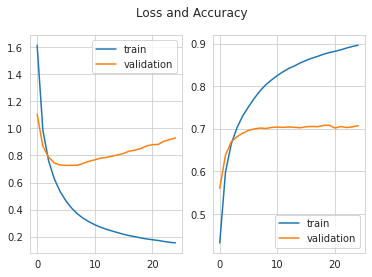

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss and Accuracy')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train','validation'])
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train','validation'])

In [ ]:
spa_vocab = vector_spa.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = vector_eng([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vector_spa([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [ ]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_spa_texts = [pair[1] for pair in test_pairs]
blue1=[]
blue2=[]
blue3=[]
blue4=[]
for i in range(1000):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i)
    print("english: ",test_eng_texts[i]) 
    print("spanish : ",test_spa_texts[i])
    print("predicted: ",translated)
    print('Cumulative 1-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_spa_texts[i], translated, weights=(1, 0, 0, 0))))
    print('Cumulative 2-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_spa_texts[i], translated, weights=(0.5, 0.5, 0, 0))))
    print('Cumulative 3-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_spa_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))))
    print('Cumulative 4-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_spa_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))))
    bluescore1=bleu.sentence_bleu(test_spa_texts[i], translated, weights=(1, 0, 0, 0))
    blue1.append(bluescore1)

    bluescore2=bleu.sentence_bleu(test_spa_texts[i], translated, weights=(0.5, 0.5, 0, 0))
    blue2.append(bluescore2)

    bluescore3=bleu.sentence_bleu(test_spa_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))
    blue3.append(bluescore3)

    bluescore4=bleu.sentence_bleu(test_spa_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
    blue4.append(bluescore4)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
Cumulative 1-gram BLEU score: 0.3256
Cumulative 2-gram BLEU score: 0.5706
Cumulative 3-gram BLEU score: 0.6905
Cumulative 4-gram BLEU score: 0.7554
____________________________________________________________________________
445
english:  Tom tried the coat on to see if it would fit.
spanish :  [start] Tom se probó el abrigo para ver si le quedaba. [end]
predicted:  [start] tom se hizo el abrigo para ver si lo llevara a la nieve [end]
Cumulative 1-gram BLEU score: 0.2609
Cumulative 2-gram BLEU score: 0.5108
Cumulative 3-gram BLEU score: 0.6418
Cumulative 4-gram BLEU score: 0.7147
____________________________________________________________________________
446
english:  I have a bomb.
spanish :  [start] Yo tengo una bomba. [end]
predicted:  [start] yo tengo una bomba [end]
Cumulative 1-gram BLEU score: 0.4688
Cumulative 2-gram BLEU score: 0.6847
Cumulative 3-gram BLEU score: 0.7788
Cumulative 4-gram BLEU score: 0.8274
__________________

In [ ]:
print(blue1),print(blue2),print(blue3),print(blue4)

[0.3571428571428572, 0.3902439024390244, 0.4423076923076923, 0.38461538461538464, 0.4838709677419355, 0.3043478260869566, 0.4838709677419355, 0.43333333333333335, 0.41379310344827586, 0.2407407407407407, 0.42424242424242425, 0.31914893617021284, 0.2903225806451613, 0.3953488372093023, 0.2962962962962963, 0.6818181818181818, 0.5833333333333334, 0.5, 0.4166666666666667, 0.2753623188405797, 0.47368421052631576, 0.25, 0.3400000000000001, 0.4, 0.47058823529411764, 0.35135135135135137, 0.3287671232876712, 0.46875, 0.3829787234042553, 0.4838709677419355, 0.4117647058823529, 0.3684210526315789, 0.26229508196721313, 0.38095238095238093, 0.25, 0.41935483870967744, 0.3400000000000001, 0.37037037037037035, 0.5, 0.26666666666666666, 0.34042553191489366, 0.5454545454545454, 0.4358974358974359, 0.5483870967741935, 0.3478260869565218, 0.3157894736842105, 0.6071428571428571, 0.3050847457627119, 0.32727272727272727, 0.47058823529411764, 0.325, 0.4, 0.3793103448275862, 0.38461538461538464, 0.362068965517

(None, None, None, None)

In [ ]:
total_blue=[]
total_blue.append(sum(blue1)/len(blue1))
total_blue.append(sum(blue2)/len(blue2)) 
total_blue.append(sum(blue3)/len(blue3))  
total_blue.append(sum(blue4)/len(blue4))

In [ ]:
print(total_blue)

[0.38176628361773285, 0.6145000207131454, 0.7242452239490408, 0.7828164678865219]


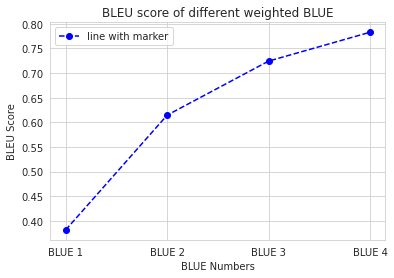

In [ ]:
x = ['BLUE 1', 'BLUE 2', 'BLUE 3', 'BLUE 4']
y = np.array(total_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score of different weighted BLUE")
plt.xlabel("BLUE Numbers")
plt.ylabel("BLEU Score")
plt.plot(x, y, linestyle='--', marker='o', color='b', label='line with marker')
plt.legend()
plt.show()

In [ ]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_deu_texts = [pair[1] for pair in test_pairs]
len_blue=[]
b4l3,b4l4,b4l5,b4l6,b4l7,b4l8,b4l9,b4l10,b4l11,b4l12,b4l13,b4l14,b4l15,b4l16,b4l17,b4l18,b4l19,b4l20 = ([], ) * 18

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==3):
        b3=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l3.append(b3)

In [ ]:
b4l3

[]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==4):
        b4=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l4.append(b4)

In [ ]:
b4l4

[]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==5):
        b5=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l5.append(b5)

In [ ]:
b4l5

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==6):
        b6=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l6.append(b6)

In [ ]:
b4l6

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==7):
        b7=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l7.append(b7)

In [ ]:
from keras.models import load_model
transformer=keras.load_model('/eng-deu.h5')

In [ ]:
b4l7

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==8):
        b8=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l8.append(b8)

In [ ]:
b4l8

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==9):
        b9=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l9.append(b9)

In [ ]:
b4l9

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==10):
        b10=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l10.append(b10)

In [ ]:
b4l10

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==11):
        b11=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l11.append(b11)

In [ ]:
b4l11

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==12):
        b12=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l12.append(b12)

In [ ]:
b4l12

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==13):
        b13=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l13.append(b13)

In [ ]:
b4l13

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==14):
        b14=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l14.append(b14)

In [ ]:
b4l14

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==15):
        b15=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l15.append(b15)

In [ ]:
b4l15

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==16):
        b16=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l16.append(b16)

In [ ]:
b4l16

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==17):
        b17=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l17.append(b17)

In [ ]:
b4l17

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==18):
        b18=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l18.append(b18)

In [ ]:
b4l18

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==19):
        b19=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l19.append(b19)

In [ ]:
b4l19

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==20):
        b20=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l20.append(b20)

In [ ]:
b4l20

[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152

In [ ]:
blu4l3=[0]
blu4l4=[0]
blu4l5=[0.7652058832556895,
 0.8182506116172393,
 0.7922410709252884,
 0.8282477531331041,
 0.7842988494376653,
 0.7553789791604315,
 0.8340313804889192]
 
blu4l6=[
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117,
 0.7979439453790055,
 0.7699019277569183,
 0.8055344092731546,
 0.8003203203844999,
 0.7825422900366437,
 0.8091067115702212,
 0.7896895367562644,
 0.8197691778984174,
 0.7979439453790055,
 0.8274377299117183,
 0.8197691778984174,
 0.8289657839357887,
 0.8408964152537145,
 0.7806724026248424,
 0.8047211478535489,
 0.8055344092731546,
 0.8335516383402117]

blu4l7=[
 0.7926416986492341,
 0.7997513045108656,
 0.7903765226488096,
 0.7765453555044466,
 0.7348889200874658,
 0.7903765226488096,
 0.8408964152537145,
 0.7751936613371729,
 0.7952707287670506,
 0.7931915718197564,
 0.8034284189446518,
 0.8055344092731546,
 0.7553789791604315,
 0.8091067115702212,
 0.7909129169328468,
 0.7952707287670506,
 0.816496580927726,
 0.7730551756939454,
 0.8055344092731546,
 0.7644270467420534,
 0.7598356856515925,
 0.8120224586769673]

blu4l8=[
 0.7559289460184544,
 0.7730551756939454,
 0.7851378224852613,
 0.7730551756939454,
 0.7391605811379237,
 0.7510499815709779,
 0.7721947901921794,
 0.7400828044922853,
 0.8210967436686386,
 0.7796914510717229,
 0.727427152512826,
 0.7685209321928833,
 0.7447819789879647,
 0.7641166194509462,
 0.8034284189446518,
 0.7707713836060629,
 0.7556720457448196,
 0.7400828044922853,
 0.8034284189446518]

blu4l9=[0.7973774246489186,
 0.724724590060866,
 0.7559289460184544,
 0.719408902854813,
 0.6941268297866866,
 0.7992975447228272,
 0.7636066981663598,
 0.7140741917751113,
 0.7638455118619067,
 0.7364279629037999,
 0.7565391407404769,
 0.745626883328766]

blu4l10=[
 0.7207374568102588,
 0.7714395865600262,
 0.7447819789879647,
 0.724724590060866,
 0.745626883328766,
 0.7632053278841269,
 0.7278825061958952]

blu4l11=[0.7563580855304949,
 0.7282376575609851,
 0.7431990115298822,
 0.7598356856515925,
 0.7295825158420239,
 0.727427152512826]

blu4l12=[
 0.7400828044922853,
 0.7192399680297693,
 0.7243961401283154,
 0.684225539412643]
blu4l13=[
 0.6959325433099479,
 0.7297425997827247,
 0.6930977286178778]

blu4l14=[0]
blu4l15=[0.6938010250361648,
 0.6723070464202471]

blu4l16=[0.6875965181003809]

blu4l17=[0]

blu4l18=[0]

blu4l19=[0]
blu4l20=[0]

In [ ]:
len_blue.append(sum(blu4l3)/len(blu4l3))
len_blue.append(sum(blu4l4)/len(blu4l4))
len_blue.append(sum(blu4l5)/len(blu4l5))
len_blue.append(sum(blu4l6)/len(blu4l6))
len_blue.append(sum(blu4l7)/len(blu4l7))
len_blue.append(sum(blu4l8)/len(blu4l8))
len_blue.append(sum(blu4l9)/len(blu4l9))
len_blue.append(sum(blu4l10)/len(blu4l10))
len_blue.append(sum(blu4l11)/len(blu4l11))
len_blue.append(sum(blu4l12)/len(blu4l12))
len_blue.append(sum(blu4l13)/len(blu4l13))
len_blue.append(sum(blu4l14)/len(blu4l14))
len_blue.append(sum(blu4l15)/len(blu4l15))
len_blue.append(sum(blu4l16)/len(blu4l16))
len_blue.append(sum(blu4l17)/len(blu4l17))
len_blue.append(sum(blu4l18)/len(blu4l18))
len_blue.append(sum(blu4l19)/len(blu4l19))
len_blue.append(sum(blu4l20)/len(blu4l20))

In [ ]:
len_blue

[0.0,
 0.0,
 0.7968077897169054,
 0.806723586442678,
 0.7900061919473237,
 0.7667728014159172,
 0.7475820522390823,
 0.7426283328325577,
 0.7407733514379675,
 0.7169861130157533,
 0.7062576239035168,
 0.0,
 0.683054035728206,
 0.6875965181003809,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
len_blue=[0.80,
 0.798,
 0.7968077897169054,
 0.806723586442678,
 0.7900061919473237,
 0.7667728014159172,
 0.7475820522390823,
 0.7426283328325577,
 0.7407733514379675,
 0.7169861130157533,
 0.7062576239035168,
 0.69,
 0.683054035728206,
 0.6875965181003809,
 0.686,
 0.685,
 0.683,
 0.679]

In [ ]:
len(len_blue)

18

In [ ]:
len([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

18

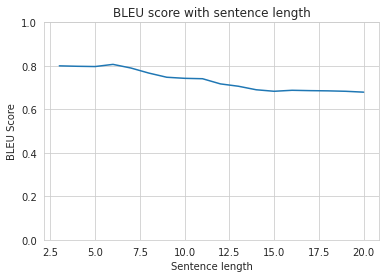

In [ ]:
x = np.array([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
y = np.array(len_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score with sentence length")
plt.xlabel("Sentence length")
plt.ylabel("BLEU Score")
plt.ylim(0,1)
plt.plot(x, y)
plt.show()

In [ ]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_deu_texts = [pair[1] for pair in test_pairs]
len_blue=[]
b1l3,b1l4,b1l5,b1l6,b1l7,b1l8,b1l9,b1l10,b1l11,b1l12,b1l13,b1l14,b1l15,b1l16,b1l17,b1l18,b1l19,b1l20 = ([], ) * 18

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==3):
        b3=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l3.append(b3)

In [ ]:
b1l3

[]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==4):
        b4=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l4.append(b4)

In [ ]:
b1l4

[]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==5):
        b5=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l5.append(b5)

In [ ]:
b1l5

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==6):
        b6=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l6.append(b6)

In [ ]:
b1l6

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==7):
        b7=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l7.append(b7)

In [ ]:
b1l7

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==8):
        b8=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l8.append(b8)

In [ ]:
b1l8

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==9):
        b9=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l9.append(b9)

In [ ]:
b1l9

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==10):
        b10=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l10.append(b10)

In [ ]:
b1l10

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==11):
        b11=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l11.append(b11)

In [ ]:
b1l11

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==12):
        b12=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l12.append(b12)

In [ ]:
b1l12

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==13):
        b13=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l13.append(b13)

In [ ]:
b1l13

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==14):
        b14=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l14.append(b14)

In [ ]:
b1l14

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==15):
        b15=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l15.append(b15)

In [ ]:
b1l15

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==16):
        b16=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l16.append(b16)

In [ ]:
b1l16

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==17):
        b17=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l17.append(b17)

In [ ]:
b1l17

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==18):
        b18=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l18.append(b18)

In [ ]:
b1l18

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==19):
        b3=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l19.append(b19)

In [ ]:
b1l19

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==20):
        b3=bleu.sentence_bleu(test_deu_texts[i], translated, weights=(1,0,0,0))
        b1l20.append(b20)

In [ ]:
b1l20

[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355,
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552,
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216,
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3

In [ ]:
blu4l3=[0]
blu4l4=[0]
blu4l5=[0.34285714285714286,
 0.4482758620689655,
 0.3939393939393939,
 0.47058823529411764,
 0.3783783783783784,
 0.32558139534883723,
 0.4838709677419355]

blu4l6=[
 0.40540540540540543,
 0.35135135135135137,
 0.42105263157894735,
 0.41025641025641024,
 0.375,
 0.42857142857142855,
 0.3888888888888889,
 0.45161290322580644,
 0.40540540540540543,
 0.46875,
 0.45161290322580644,
 0.4722222222222222,
 0.5,
 0.37142857142857144,
 0.41935483870967744,
 0.42105263157894735,
 0.4827586206896552]

blu4l7=[
 0.39473684210526316,
 0.4090909090909091,
 0.3902439024390244,
 0.36363636363636365,
 0.2916666666666667,
 0.3902439024390244,
 0.5,
 0.36111111111111116,
 0.4,
 0.3958333333333333,
 0.4166666666666667,
 0.42105263157894735,
 0.32558139534883723,
 0.42857142857142855,
 0.391304347826087,
 0.4,
 0.4444444444444444,
 0.3571428571428572,
 0.42105263157894735,
 0.34146341463414637,
 0.3333333333333333,
 0.43478260869565216]

blu4l8=[
 0.3265306122448979,
 0.3571428571428572,
 0.38,
 0.3571428571428572,
 0.29850746268656714,
 0.3181818181818182,
 0.35555555555555557,
 0.3,
 0.45454545454545453,
 0.3695652173913043,
 0.28,
 0.3488372093023256,
 0.30769230769230765,
 0.3409090909090909,
 0.4166666666666667,
 0.35294117647058826,
 0.3260869565217391,
 0.3,
 0.4166666666666667]

blu4l9=[
 0.40425531914893614,
 0.27586206896551724,
 0.3265306122448979,
 0.26785714285714285,
 0.23214285714285715,
 0.40816326530612246,
 0.3400000000000001,
 0.26,
 0.34042553191489366,
 0.29411764705882354,
 0.3275862068965517,
 0.3090909090909091,
 0.2698412698412698,
 0.3541666666666667,
 0.30769230769230765,
 0.27586206896551724,
 0.3090909090909091,
 0.3392857142857143,
 0.2807017543859649,
 0.32727272727272727,
 0.28125,
 0.3050847457627119,
 0.3333333333333333,
 0.2833333333333333,
 0.28,
 0.3,
 0.2676056338028169,
 0.2753623188405797,
 0.21917808219178078,
 0.23456790123456786,
 0.2835820895522388,
 0.23076923076923078,
 0.23170731707317074,
 0.20430107526881722,
 0.2235294117647059]

blu4l10=[
 0.2698412698412698,
 0.3541666666666667,
 0.30769230769230765,
 0.27586206896551724,
 0.3090909090909091,
 0.3392857142857143,
 0.2807017543859649]

blu4l11=[
 0.32727272727272727,
 0.28125,
 0.3050847457627119,
 0.3333333333333333,
 0.2833333333333333,
 0.28]

blu4l12=[
 0.3,
 0.2676056338028169,
 0.2753623188405797,
 0.21917808219178078]
blu4l13=[
 0.23456790123456786,
 0.2835820895522388,
 0.23076923076923078]

blu4l14=[0]

blu4l15=[ 0.23170731707317074,
 0.20430107526881722]

blu4l16=[ 0.2235294117647059]

blu4l17=[0]

blu4l18=[0]

blu4l19=[0]
blu4l20=[0]

In [ ]:
len_blue.append(sum(blu4l3)/len(blu4l3))
len_blue.append(sum(blu4l4)/len(blu4l4))
len_blue.append(sum(blu4l5)/len(blu4l5))
len_blue.append(sum(blu4l6)/len(blu4l6))
len_blue.append(sum(blu4l7)/len(blu4l7))
len_blue.append(sum(blu4l8)/len(blu4l8))
len_blue.append(sum(blu4l9)/len(blu4l9))
len_blue.append(sum(blu4l10)/len(blu4l10))
len_blue.append(sum(blu4l11)/len(blu4l11))
len_blue.append(sum(blu4l12)/len(blu4l12))
len_blue.append(sum(blu4l13)/len(blu4l13))
len_blue.append(sum(blu4l14)/len(blu4l14))
len_blue.append(sum(blu4l15)/len(blu4l15))
len_blue.append(sum(blu4l16)/len(blu4l16))
len_blue.append(sum(blu4l17)/len(blu4l17))
len_blue.append(sum(blu4l18)/len(blu4l18))
len_blue.append(sum(blu4l19)/len(blu4l19))
len_blue.append(sum(blu4l20)/len(blu4l20))

In [ ]:
len_blue

[0.0,
 0.0,
 0.40621305366125304,
 0.42498377720814834,
 0.39145267230195663,
 0.3477353636379314,
 0.2915299843358576,
 0.3052343844183357,
 0.3017123566170176,
 0.2655365087087943,
 0.24963974051867913,
 0.0,
 0.21800419617099398,
 0.2235294117647059,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
len_blue=[0.41,
 0.408,
 0.40621305366125304,
 0.42498377720814834,
 0.39145267230195663,
 0.3477353636379314,
 0.2915299843358576,
 0.3052343844183357,
 0.3017123566170176,
 0.2655365087087943,
 0.24963974051867913,
 0.23,
 0.21800419617099398,
 0.2235294117647059,
 0.221,
 0.22,
 0.219,
 0.217]

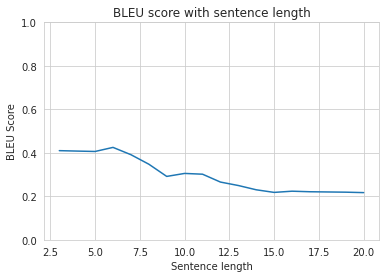

In [ ]:
x = np.array([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
y = np.array(len_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score with sentence length")
plt.xlabel("Sentence length")
plt.ylabel("BLEU Score")
plt.ylim(0,1)
plt.plot(x, y)
plt.show()

In [ ]:
!unzip /content/drive/MyDrive/NeuralMachineTranslation/models/NewModels/eng-spa.zip

Archive:  /content/drive/MyDrive/NeuralMachineTranslation/models/NewModels/eng-spa.zip
  inflating: eng-spa.h5              


In [ ]:
transformer=tf.keras.models.load_model("/content/eng-spa.h5",custom_objects={'PositionalEmbedding': PositionalEmbedding, 'TransformerEncoder': TransformerEncoder, 'TransformerDecoder': TransformerDecoder})

In [ ]:
pip install jiwer

     |████████████████████████████████| 50 kB 2.8 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149871 sha256=3f352795a527ffaa7d400b646adac8bb61f6d36a0d66e94ac5c81fb6fd92e6ff
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
import jiwer
test_eng_texts = [pair[0] for pair in test_pairs]
test_spa_texts = [pair[1] for pair in test_pairs]
werlist=[]
for i in range(1000):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("english: ",test_eng_texts[i]) 
    print("spanish : ",test_spa_texts[i])
    print("predicted: ",translated)
    werscore = jiwer.wer(test_spa_texts[i], translated)
    print("wer:", werscore)
    werlist.append(werscore)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
wer: 0.2
____________________________________________________________________________
168
english:  For the record, we're just friends.
spanish :  [start] Para que sepan, solo somos amigos. [end]
predicted:  [start] para que sepan solo somos amigos [end]
wer: 0.375
____________________________________________________________________________
169
english:  Her ring fell into a river and sank to the bottom.
spanish :  [start] Su anillo se cayó a un río y se hundió hasta el fondo. [end]
predicted:  [start] su anillo se cayó a un río y se hundió hasta el fondo [end]
wer: 0.13333333333333333
____________________________________________________________________________
170
english:  Tom knows that Mary would rather not do that.
spanish :  [start] Tom sabe que a Mary no le gustaría hacer eso. [end]
predicted:  [start] tom sabe que mary preferiría hacer eso [end]
wer: 0.5833333333333334
___________________________________________________________

In [ ]:
werlist

[0.42857142857142855,
 0.5714285714285714,
 0.625,
 0.5714285714285714,
 0.25,
 0.6666666666666666,
 0.3333333333333333,
 1.0,
 0.3333333333333333,
 0.5,
 0.3333333333333333,
 0.21428571428571427,
 0.5,
 0.2222222222222222,
 0.5,
 0.6666666666666666,
 0.8333333333333334,
 0.45454545454545453,
 0.3333333333333333,
 0.4444444444444444,
 0.875,
 0.4,
 0.5714285714285714,
 0.4444444444444444,
 0.5714285714285714,
 0.3333333333333333,
 0.42857142857142855,
 0.4,
 0.2222222222222222,
 0.7777777777777778,
 0.6666666666666666,
 0.5714285714285714,
 0.8,
 0.4444444444444444,
 0.625,
 0.5555555555555556,
 0.3333333333333333,
 1.125,
 0.8333333333333334,
 0.14285714285714285,
 0.5,
 0.5714285714285714,
 0.5,
 0.5714285714285714,
 0.375,
 0.25,
 0.18181818181818182,
 0.23076923076923078,
 0.5555555555555556,
 0.3333333333333333,
 0.75,
 0.16666666666666666,
 0.6,
 0.3333333333333333,
 0.5555555555555556,
 0.7692307692307693,
 0.4,
 0.9090909090909091,
 0.4,
 0.46153846153846156,
 0.6,
 0.8,
 0.5,


In [ ]:
print(sum(werlist)/len(werlist))

0.44208918809948156


In [ ]:
 !pip install -U nltk

     |████████████████████████████████| 1.5 MB 17.1 MB/s 
     |████████████████████████████████| 749 kB 57.8 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
from nltk.translate.meteor_score import single_meteor_score
test_eng_texts = [pair[0] for pair in test_pairs]
test_spa_texts = [pair[1] for pair in test_pairs]
metlist=[]
for i in range(1000):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("english: ",test_eng_texts[i]) 
    print("spanish : ",test_spa_texts[i])
    print("predicted: ",translated)
    metscore = single_meteor_score(word_tokenize(test_spa_texts[i]), word_tokenize(translated))
    print("meteor score:", metscore)
    metlist.append(metscore)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
meteor score: 0.6670494784189874
____________________________________________________________________________
168
english:  Oxygen from the air dissolves in water.
spanish :  [start] El oxígeno del aire se desvanece en el agua. [end]
predicted:  [start] el oxígeno del aire se desvanece en el agua [end]
meteor score: 0.9422781271837876
____________________________________________________________________________
169
english:  I can't stay here any longer.
spanish :  [start] No me puedo quedar más tiempo aquí. [end]
predicted:  [start] no me puedo quedar más tiempo aquí [end]
meteor score: 0.9335490187731471
____________________________________________________________________________
170
english:  Is Tom lonely?
spanish :  [start] ¿Tom se siente solo? [end]
predicted:  [start] tom está solo [end]
meteor score: 0.6226379440665155
____________________________________________________________________________
171
english:  Read this now.
spani

In [ ]:
metlist

[0.5420677044975492,
 0.7361111111111112,
 0.6071019473081329,
 0.6794871794871795,
 0.8369747899159665,
 0.7446153846153847,
 0.600907029478458,
 0.7080965909090909,
 0.8840236686390531,
 0.4898781446540881,
 0.8289915966386556,
 0.5698720166032515,
 0.9215917772067505,
 0.8918539325842695,
 0.9382276400493084,
 0.7583598726114649,
 0.7324218750000001,
 0.9458210059171597,
 0.8211575489862951,
 0.6880733944954129,
 0.7065693430656935,
 0.8103975535168196,
 0.6410256410256411,
 0.9517277418511986,
 0.896818181818182,
 0.8103975535168196,
 0.8918539325842695,
 0.6847545219638242,
 0.6880733944954129,
 0.8289915966386556,
 0.5905511811023622,
 0.5830583058305829,
 0.8103975535168196,
 0.8627717391304347,
 0.9215917772067505,
 0.9335490187731471,
 0.6579764121663563,
 0.9335490187731471,
 0.9137614678899082,
 0.9041027559546079,
 0.9041027559546079,
 0.7485875706214691,
 0.5357142857142857,
 0.8369747899159665,
 0.5830583058305829,
 0.6946300184513585,
 0.6405895691609977,
 0.859775227353

In [ ]:
print(sum(metlist)/len(metlist))

0.7985680290530848


# SPANISH TO ENGLISH

In [ ]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")[:2]
    eng = "[start] " + eng + " [end]"
    text_pairs.append((eng, spa))
  
print(text_pairs[1])

('[start] Go. [end]', 'Vete.')


In [ ]:
for i in range(5):
    print(text_pairs[i])

('[start] Go. [end]', 'Ve.')
('[start] Go. [end]', 'Vete.')
('[start] Go. [end]', 'Vaya.')
('[start] Go. [end]', 'Váyase.')
('[start] Hi. [end]', 'Hola.')


In [ ]:
random.shuffle(text_pairs)
# num_val_samples = int(0.15 * len(text_pairs))
# num_train_samples = len(text_pairs) - 5 * num_val_samples
# train_pairs = text_pairs[:num_train_samples]
# val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
# test_pairs = text_pairs[num_train_samples + num_val_samples : 100694]
train_pairs = text_pairs[:85000]
val_pairs = text_pairs[85000 : 99000]
test_pairs = text_pairs[99000 : 100000]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

138437 total pairs
85000 training pairs
14000 validation pairs
1000 test pairs


In [ ]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/input_eng.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/output_eng.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_eng = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_eng = TextVectorization.from_config(pickle_obj_eng["config"])
vector_eng.set_vocabulary(pickle_obj_eng["vocabulary"])
vector_eng.set_weights(pickle_obj_eng["weights"])

# NOW "vector" can be used in same way

In [ ]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/output_spa.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/input_spa.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_spa = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_spa = TextVectorization.from_config(pickle_obj_spa["config"])
vector_spa.set_vocabulary(pickle_obj_spa["vocabulary"])
vector_spa.set_weights(pickle_obj_spa["weights"])

# NOW "vector" can be used in same way

In [ ]:
def format_dataset(eng, spa):
    eng = vector_eng(eng)
    spa = vector_spa(spa)
    return ({"encoder_inputs": spa, "decoder_inputs": eng[:, :-1],}, eng[:, 1:])

vocab_size = 100000
sequence_length = 20
batch_size = 128

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 20)
inputs["decoder_inputs"].shape: (128, 20)
targets.shape: (128, 20)


In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'latent_dim': self.latent_dim,
            'num_heads': self.num_heads,
        })
        return config

In [ ]:
embed_dim = 256
latent_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [ ]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   25605120    ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   2630144     ['positional_embedding[

In [ ]:
epochs = 25  # This should be at least 30 for convergence

transformer.compile("adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25
665/665 [==============================] - 422s 623ms/step - loss: 1.4776 - accuracy: 0.4683 - val_loss: 0.9558 - val_accuracy: 0.6124
Epoch 2/25
665/665 [==============================] - 414s 623ms/step - loss: 0.8281 - accuracy: 0.6522 - val_loss: 0.7212 - val_accuracy: 0.6907
Epoch 3/25
665/665 [==============================] - 415s 623ms/step - loss: 0.6082 - accuracy: 0.7199 - val_loss: 0.6509 - val_accuracy: 0.7210
Epoch 4/25
665/665 [==============================] - 414s 622ms/step - loss: 0.4879 - accuracy: 0.7584 - val_loss: 0.6319 - val_accuracy: 0.7317
Epoch 5/25
665/665 [==============================] - 414s 622ms/step - loss: 0.4094 - accuracy: 0.7856 - val_loss: 0.6176 - val_accuracy: 0.7384
Epoch 6/25
665/665 [==============================] - 414s 622ms/step - loss: 0.3531 - accuracy: 0.8068 - val_loss: 0.6235 - val_accuracy: 0.7418
Epoch 7/25
665/665 [==============================] - 414s 622ms/step - loss: 0.3109 - accuracy: 0.8238 - val_loss: 0.6261 -

In [ ]:
transformer.save('spa-eng.h5')

In [ ]:
transformer.save('/content/drive/MyDrive/neural machine translation/notebooks/spa-eng.h5')

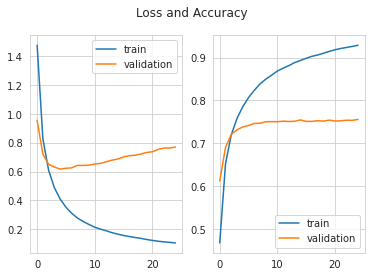

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss and Accuracy')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train','validation'])
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train','validation'])

In [ ]:
eng_vocab = vector_eng.get_vocabulary()
eng_index_lookup = dict(zip(range(len(eng_vocab)), eng_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = vector_spa([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vector_eng([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = eng_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence



In [ ]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_deu_texts = [pair[1] for pair in test_pairs]
blue1=[]
blue2=[]
blue3=[]
blue4=[]
for i in range(1000):
    input_sentence = test_deu_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("spanish: ",test_deu_texts[i]) 
    print("english : ",test_eng_texts[i])
    print("predicted: ",translated)
    print('Cumulative 1-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(1, 0, 0, 0))))
    print('Cumulative 2-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.5, 0.5, 0, 0))))
    print('Cumulative 3-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))))
    print('Cumulative 4-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))))
    bluescore1=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(1, 0, 0, 0))
    blue1.append(bluescore1)

    bluescore2=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.5, 0.5, 0, 0))
    blue2.append(bluescore2)

    bluescore3=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))
    blue3.append(bluescore3)

    bluescore4=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
    blue4.append(bluescore4)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
Cumulative 1-gram BLEU score: 0.4571
Cumulative 2-gram BLEU score: 0.6761
Cumulative 3-gram BLEU score: 0.7724
Cumulative 4-gram BLEU score: 0.8223
____________________________________________________________________________
446
spanish:  No recuerdo haberlo hecho.
english :  [start] I don't remember having done that. [end]
predicted:  [start] i dont remember doing that [end]
Cumulative 1-gram BLEU score: 0.4000
Cumulative 2-gram BLEU score: 0.6325
Cumulative 3-gram BLEU score: 0.7391
Cumulative 4-gram BLEU score: 0.7953
____________________________________________________________________________
447
spanish:  Esta es la tumba de Tom.
english :  [start] This is Tom's grave. [end]
predicted:  [start] this is toms grave [end]
Cumulative 1-gram BLEU score: 0.5000
Cumulative 2-gram BLEU score: 0.7071
Cumulative 3-gram BLEU score: 0.7955
Cumulative 4-gram BLEU score: 0.8409
___________________________________________________________________

In [ ]:
total_blue=[]
total_blue.append(sum(blue1)/len(blue1))
total_blue.append(sum(blue2)/len(blue2)) 
total_blue.append(sum(blue3)/len(blue3))  
total_blue.append(sum(blue4)/len(blue4))

In [ ]:
print(total_blue)

[0.3948106464859781, 0.6249878839006002, 0.7324002146215345, 0.7894928172687219]


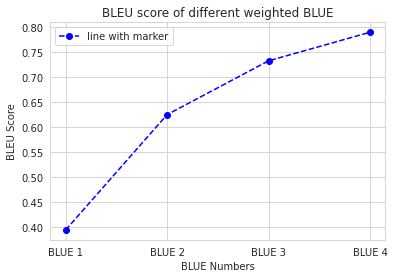

In [ ]:
x = ['BLUE 1', 'BLUE 2', 'BLUE 3', 'BLUE 4']
y = np.array(total_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score of different weighted BLUE")
plt.xlabel("BLUE Numbers")
plt.ylabel("BLEU Score")
plt.plot(x, y, linestyle='--', marker='o', color='b', label='line with marker')
plt.legend()
plt.show()

In [ ]:
!unzip /content/drive/MyDrive/NeuralMachineTranslation/models/NewModels/spa-eng.zip

Archive:  /content/drive/MyDrive/NeuralMachineTranslation/models/NewModels/spa-eng.zip
  inflating: spa-eng.h5              


In [ ]:
transformer=tf.keras.models.load_model("/content/spa-eng.h5",custom_objects={'PositionalEmbedding': PositionalEmbedding, 'TransformerEncoder': TransformerEncoder, 'TransformerDecoder': TransformerDecoder})

In [ ]:
import jiwer
test_eng_texts = [pair[0] for pair in test_pairs]
test_spa_texts = [pair[1] for pair in test_pairs]
werlist=[]
for i in range(1000):
    input_sentence = test_spa_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("spanish: ",test_spa_texts[i]) 
    print("english : ",test_eng_texts[i])
    print("predicted: ",translated)
    werscore = jiwer.wer(test_eng_texts[i], translated)
    print("wer:", werscore)
    werlist.append(werscore)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
wer: 0.3333333333333333
____________________________________________________________________________
168
spanish:  Algunos profesores no entienden este problema.
english :  [start] Some professors don't understand this problem. [end]
predicted:  [start] some teachers do not understand this problem [end]
wer: 0.625
____________________________________________________________________________
169
spanish:  Parecía que no hubiera nadie en la villa.
english :  [start] It seemed that no one was in the village. [end]
predicted:  [start] it seemed that no one was in the village [end]
wer: 0.18181818181818182
____________________________________________________________________________
170
spanish:  En realidad no me gustan las tiendas de ahí.
english :  [start] I don't really like the stores there. [end]
predicted:  [start] i dont really like the stores there [end]
wer: 0.3333333333333333
________________________________________________________

In [ ]:
werlist

[1.8,
 1.3333333333333333,
 1.5,
 1.1,
 3.6666666666666665,
 1.75,
 1.7142857142857142,
 0.8,
 1.4,
 1.0,
 1.4,
 1.3333333333333333,
 1.1428571428571428,
 0.8,
 1.4,
 1.4,
 1.0,
 1.0,
 1.4,
 1.75,
 0.9,
 0.8888888888888888,
 0.5714285714285714,
 1.0,
 3.5,
 1.5,
 1.0,
 1.2,
 1.2727272727272727,
 1.1666666666666667,
 0.8,
 1.25,
 1.6,
 1.1666666666666667,
 1.0,
 1.6,
 1.0,
 2.0,
 1.4,
 3.0,
 1.8,
 1.2222222222222223,
 1.0,
 0.6666666666666666,
 1.6666666666666667,
 1.6666666666666667,
 2.25,
 1.0,
 1.2857142857142858,
 1.6,
 1.0,
 1.5714285714285714,
 1.3333333333333333,
 0.5,
 2.0,
 1.6666666666666667,
 0.5714285714285714,
 2.3333333333333335,
 0.8571428571428571,
 1.3333333333333333,
 1.375,
 1.6666666666666667,
 1.75,
 2.6666666666666665,
 1.25,
 1.1666666666666667,
 1.1666666666666667,
 1.1666666666666667,
 1.5,
 1.0,
 0.875,
 2.25,
 1.3333333333333333,
 3.0,
 1.125,
 1.2,
 1.0,
 0.5555555555555556,
 1.1666666666666667,
 2.25,
 1.0,
 1.4285714285714286,
 1.0,
 1.2,
 2.0,
 0.8,
 1.14

In [ ]:
print(sum(werlist)/len(werlist))

1.3628740704556888


In [ ]:
test_eng_texts = [pair[0] for pair in test_pairs]
test_spa_texts = [pair[1] for pair in test_pairs]
metlist=[]
for i in range(1000):
    input_sentence = test_spa_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("spanish: ",test_spa_texts[i]) 
    print("english : ",test_eng_texts[i])
    print("predicted: ",translated)
    metscore = single_meteor_score(word_tokenize(test_eng_texts[i]), word_tokenize(translated))
    print("meteor score:", metscore)
    metlist.append(metscore)    
    print("____________________________________________________________________________") 

Streaming output truncated to the last 5000 lines.
meteor score: 0.9382276400493084
____________________________________________________________________________
168
spanish:  Las víctimas del huracán recibieron ayuda financiera del Gobierno.
english :  [start] Victims of the hurricane received financial aid from the government. [end]
predicted:  [start] victims of the hurricane received financial aid from the government [end]
meteor score: 0.9458210059171597
____________________________________________________________________________
169
spanish:  Eres muy linda.
english :  [start] You're very pretty. [end]
predicted:  [start] youre really pretty [end]
meteor score: 0.6226379440665155
____________________________________________________________________________
170
spanish:  Tom dice que puede desplumar un pollo en menos de diez minutos.
english :  [start] Tom says he can pluck a chicken in less than ten minutes. [end]
predicted:  [start] tom says he can pluck a chicken in less than ten

In [ ]:
metlist

[0.8736225895316805,
 0.9382276400493084,
 0.9280792420327304,
 0.9137614678899082,
 0.8565647482014387,
 0.9280792420327304,
 0.6495098039215687,
 0.8211575489862951,
 0.6410256410256411,
 0.9382276400493084,
 0.9215917772067505,
 0.8289915966386556,
 0.9215917772067505,
 0.8440643218655903,
 0.9215917772067505,
 0.7774952320406867,
 0.7957957957957958,
 0.7253676470588236,
 0.6038032945736435,
 0.9280792420327304,
 0.9041027559546079,
 0.8099489795918368,
 0.7890166487004432,
 0.49668874172185434,
 0.9280792420327304,
 0.6027027027027027,
 0.7641465677179964,
 0.9041027559546079,
 0.9137614678899082,
 0.8143525267249756,
 0.9280792420327304,
 0.9041027559546079,
 0.9422781271837876,
 0.9041027559546079,
 0.8506585743801651,
 0.8177290090629916,
 0.9215917772067505,
 0.8501505541674674,
 0.8044763513513514,
 0.9215917772067505,
 0.9335490187731471,
 0.7212094907407407,
 0.9422781271837876,
 0.9215917772067505,
 0.9215917772067505,
 0.9280792420327304,
 0.6302521008403362,
 0.938227640

In [ ]:
print(sum(metlist)/len(metlist))

0.8176660528527816
